% For reference:
% The [tutorial guidelines](https://github.com/aiidateam/aiida-core/wiki/Writing-documentation#tutorial).
% See [issue #3981](https://github.com/aiidateam/aiida-core/issues/3981).

(tutorial)=
(tutorial:basic)=
# Basic tutorial

The goal of this tutorial is to give you an idea of how AiiDA helps you in executing data-driven workflows.
At the end of this tutorial, you will know how to:

- Store data in the database and subsequently retrieve it.
- Decorate a Python function such that its inputs and outputs are automatically tracked.
- Run and monitor the status of processes.
- Explore and visualize the provenance graph.

:::{important}
If you are working on your own machine, note that the tutorial assumes that you have a working AiiDA installation and have set up your AiiDA profile in the current Python environment.
If this is not the case, consult the {ref}`getting started page<intro:get_started>`.
:::

:::{tip}
This tutorial can be downloaded and run as a Jupyter Notebook: {nb-download}`basic.ipynb` {octicon}`download`
:::

In [1]:
from aiida import load_profile, engine, orm, plugins
from aiida.manage.configuration import get_config
from aiida.storage.sqlite_temp import SqliteTempBackend

%load_ext aiida

profile = load_profile(
    SqliteTempBackend.create_profile(
        'myprofile',
        options={
            'warnings.development_version': False,
            'runner.poll.interval': 1
        },
        debug=False
    ),
    allow_switch=True
)
config = get_config()
config.add_profile(profile)
config.set_default_profile(profile.name)
profile

Profile<uuid='13964614b4154ec998daddb8a9ae137a' name='myprofile'>

## Provenance

Before we dive in, we need to briefly introduce one of the most important concepts for AiiDA: *provenance*.
An AiiDA database does not only contain the results of your calculations, but also their inputs and each step that was executed to obtain them.
All of this information is stored in the form of a *directed acyclic graph* (DAG).
As an example, {numref}`fig_intro_workchain_graph` shows the provenance of the calculations of this tutorial.

(fig_intro_workchain_graph)=

:::{figure} include/workchain_graph.png
:align: center
:scale: 30

Provenance Graph of a basic AiiDA WorkChain.
:::

In the provenance graph, you can see different types of *nodes* represented by different shapes.
The green ellipses are `Data` nodes, the blue ellipse is a `Code` node, and the rectangles represent *processes*, i.e. the calculations performed in your *workflow*.

The provenance graph allows us to not only see what data we have, but also how it was produced.
During this tutorial, we will be using AiiDA to generate the provenance graph in {numref}`fig_intro_workchain_graph` step by step.

## Data nodes

Before running any calculations, let's create and store a *data node*.
AiiDA ships with an interactive IPython shell that has many basic AiiDA classes pre-loaded.
To start the IPython shell, simply type in the terminal:

```console
$ verdi shell
```

AiiDA implements data node types for the most common types of data (int, float, str, etc.), which you can extend with your own (composite) data node types if needed.
For this tutorial, we'll keep it very simple, and start by initializing an `Int` node and assigning it to the `node` variable:

In [2]:
from aiida import orm

node = orm.Int(2)

We can check the contents of the `node` variable like this:

In [3]:
node

<Int: uuid: 055290fd-504e-44e8-be04-3e4a32d20f23 (unstored) value: 2>

Quite a bit of information on our freshly created node is returned:

- The data node is of the type `Int`
- The node has the *universally unique identifier* (**UUID**) `eac48d2b-ae20-438b-aeab-2d02b69eb6a8`
- The node is currently not stored in the database `(unstored)`
- The integer value of the node is `2`

Let's store the node in the database:

In [4]:
node.store()

<Int: uuid: 055290fd-504e-44e8-be04-3e4a32d20f23 (pk: 1) value: 2>

As you can see, the data node has now been assigned a *primary key* (**PK**), a number that identifies the node in your database `(pk: 1)`.
The PK and UUID both reference the node with the only difference that the PK is unique *for your local database only*, whereas the UUID is a globally unique identifier and can therefore be used between *different* databases.
Use the PK only if you are working within a single database, i.e. in an interactive session and the UUID in all other cases.

:::{important}
The PK numbers shown throughout this tutorial assume that you start from a completely empty database.
It is possible that the nodes' PKs will be different for your database!

The UUIDs are generated randomly and are, therefore, **guaranteed** to be different.
:::

Next, let's leave the IPython shell by typing `exit()` and then enter.
Back in the terminal, use the `verdi` command line interface (CLI) to check the data node we have just created:

In [5]:
%verdi node show 1

Property     Value
-----------  ------------------------------------
type         Int
pk           1
uuid         055290fd-504e-44e8-be04-3e4a32d20f23
label
description
ctime        2024-05-05 04:12:19.616539+00:00
mtime        2024-05-05 04:12:19.675130+00:00


Once again, we can see that the node is of type `Int`, has PK = 1, and UUID = `eac48d2b-ae20-438b-aeab-2d02b69eb6a8`.
Besides this information, the `verdi node show` command also shows the (empty) `label` and `description`, as well as the time the node was created (`ctime`) and last modified (`mtime`).

:::{note}
AiiDA already provides many standard data types, but you can also {ref}`create your own<topics:data_types:plugin>`.
:::

## Calculation functions

Once your data is stored in the database, it is ready to be used for some computational task.
For example, let's say you want to multiply two `Int` data nodes.
The following Python function:

```python
def multiply(x, y):
    return x * y
```

will give the desired result when applied to two `Int` nodes, but the calculation will not be stored in the provenance graph.
However, we can use a [Python decorator](https://docs.python.org/3/glossary.html#term-decorator) provided by AiiDA to automatically make it part of the provenance graph.
Start up the AiiDA IPython shell again using `verdi shell` and execute the following code snippet:

In [6]:
from aiida import engine

@engine.calcfunction
def multiply(x, y):
    return x * y

This converts the `multiply` function into an AiIDA *calculation function*, the most basic execution unit in AiiDA.
Next, load the `Int` node you have created in the previous section using the `load_node` function and the PK of the data node:

In [7]:
x = orm.load_node(pk=1)

Of course, we need another integer to multiply with the first one.
Let's create a new `Int` data node and assign it to the variable `y`:

In [8]:
y = orm.Int(3)

Now it's time to multiply the two numbers!

In [9]:
multiply(x, y)

<Int: uuid: 188fbd41-24eb-470a-8c5f-aaf9ebbaf841 (pk: 4) value: 6>

Success!
The `calcfunction`-decorated `multiply` function has multiplied the two `Int` data nodes and returned a new `Int` data node whose value is the product of the two input nodes.
Note that by executing the `multiply` function, all input and output nodes are automatically stored in the database:

In [10]:
y

<Int: uuid: bfaba1a1-c0f6-4173-88e0-a37c0db4d095 (pk: 2) value: 3>

We had not yet stored the data node assigned to the `y` variable, but by providing it as an input argument to the `multiply` function, it was automatically stored with PK = 2.
Similarly, the returned `Int` node with value 6 has been stored with PK = 4.

Let's once again leave the IPython shell with `exit()` and look for the process we have just run using the `verdi` CLI:

In [11]:
%verdi process list

PK    Created    Process label    ♻    Process State    Process status
----  ---------  ---------------  ---  ---------------  ----------------

Total results: 0

Report: ♻ Processes marked with check-mark were not run but taken from the cache.
Report: Add the option `-P pk cached_from` to the command to display cache source.
Report: Last time an entry changed state: 0s ago (at 04:12:20 on 2024-05-05)



Total results: 0



Report: ♻ Processes marked with check-mark were not run but taken from the cache.


Report: Add the option `-P pk cached_from` to the command to display cache source.


Report: Last time an entry changed state: 0s ago (at 04:12:20 on 2024-05-05)


The returned list will be empty, but don't worry!
By default, `verdi process list` only returns the *active* processes.
If you want to see *all* processes (i.e. also the processes that are *terminated*), simply add the `-a` option:

In [12]:
%verdi process list -a

  PK  Created    Process label    ♻    Process State    Process status
----  ---------  ---------------  ---  ---------------  ----------------
   3  0s ago     multiply              ⏹ Finished [0]

Total results: 1

Report: ♻ Processes marked with check-mark were not run but taken from the cache.
Report: Add the option `-P pk cached_from` to the command to display cache source.
Report: Last time an entry changed state: 0s ago (at 04:12:20 on 2024-05-05)



Total results: 1



Report: ♻ Processes marked with check-mark were not run but taken from the cache.


Report: Add the option `-P pk cached_from` to the command to display cache source.


Report: Last time an entry changed state: 0s ago (at 04:12:20 on 2024-05-05)


We can see that our `multiply` calcfunction was created 1 minute ago, assigned the PK 3, and has `Finished`.

As a final step, let's have a look at the provenance of this simple calculation.
The provenance graph can be automatically generated using the verdi CLI.
Let's generate the provenance graph for the `multiply` calculation function we have just run with PK = 3:

```console
$ verdi node graph generate 3
```

The command will write the provenance graph to a `.pdf` file.
Use your favorite PDF viewer to have a look.
It should look something like the graph shown below.

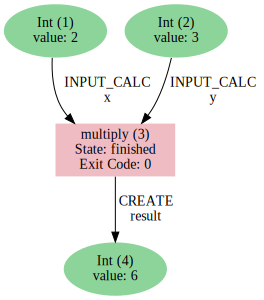

In [13]:
from aiida.tools.visualization import Graph
graph = Graph()
calc_node = orm.load_node(3)
graph.add_incoming(calc_node, annotate_links="both")
graph.add_outgoing(calc_node, annotate_links="both")
graph.graphviz

:::{note}
Remember that the PK of the `CalcJob` can be different for your database.
:::

(tutorial:basic:calcjob)=

## CalcJobs

When running calculations that require an external code or run on a remote machine, a simple calculation function is no longer sufficient.
For this purpose, AiiDA provides the `CalcJob` process class.

To run a `CalcJob`, you need to set up two things: a `code` that is going to implement the desired calculation and a `computer` for the calculation to run on.

If you're running this tutorial in the Quantum Mobile VM or on Binder, these have been pre-configured for you. If you're running on your own machine, you can follow the instructions in the panel below.

:::{seealso}
More details for how to {ref}`run external codes <how-to:run-codes>`.
:::

:::{dropdown} Install localhost computer and code

Let's begin by setting up the computer using the ``verdi computer`` subcommand:

```console
$ verdi computer setup -L tutor -H localhost -T core.local -S core.direct -w `echo $PWD/work` -n
$ verdi computer configure core.local tutor --safe-interval 1 -n
```

The first commands sets up the computer with the following options:

- *label* (`-L`): tutor
- *hostname* (`-H`): localhost
- *transport* (`-T`): local
- *scheduler* (`-S`): direct
- *work-dir* (`-w`): The `work` subdirectory of the current directory

The second command *configures* the computer with a minimum interval between connections (`--safe-interval`) of 1 second.
For both commands, the *non-interactive* option (`-n`) is added to not prompt for extra input.

Next, let's set up the code we're going to use for the tutorial:

```console
$ verdi code create core.code.installed --label add --computer=tutor --default-calc-job-plugin core.arithmetic.add --filepath-executable=/bin/bash -n
```

This command sets up a code with *label* `add` on the *computer* `tutor`, using the *plugin* `core.arithmetic.add`.

:::

In [14]:
%verdi computer setup -L tutor -H localhost -T core.local -S core.direct -w /tmp -n
%verdi computer configure core.local tutor --safe-interval 0 -n
%verdi code create core.code.installed --label add --computer=tutor --default-calc-job-plugin core.arithmetic.add --filepath-executable=/bin/bash -n

Success: Computer<1> tutor created
Report: Note: before the computer can be used, it has to be configured with the command:
Report:   verdi -p myprofile computer configure core.local tutor
Report: Configuring computer tutor for user user@email.com.
Success: tutor successfully configured for user@email.com
Success: Created InstalledCode<5>


Report: Note: before the computer can be used, it has to be configured with the command:


Report:   verdi -p myprofile computer configure core.local tutor


Report: Configuring computer tutor for user user@email.com.


Success: tutor successfully configured for user@email.com


Success: Created InstalledCode<5>


/home/docs/checkouts/readthedocs.org/user_builds/aiida-core/envs/latest/lib/python3.10/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `str` but got `Computer` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
/home/docs/checkouts/readthedocs.org/user_builds/aiida-core/envs/latest/lib/python3.10/site-packages/aiida/orm/nodes/data/code/legacy.py:78: AiidaDeprecationWarning: The `Code` class is deprecated. To create an instance, use the `aiida.orm.nodes.data.code.installed.InstalledCode` or `aiida.orm.nodes.data.code.portable.PortableCode` for a "remote" or "local" code, respectively. If you are using this class to compare type, e.g. in `isinstance`, use `aiida.orm.nodes.data.code.abstract.AbstractCode`. (this will be removed in v3)
  warn_deprecation(


A typical real-world example of a computer is a remote supercomputing facility.
Codes can be anything from a Python script to powerful *ab initio* codes such as Quantum Espresso or machine learning tools like Tensorflow.
Let's have a look at the codes that are available to us:

In [15]:
%verdi code list

Full label      Pk  Entry point
------------  ----  -------------------
add@tutor        5  core.code.installed

Use `verdi code show IDENTIFIER` to see details for a code



Use `verdi code show IDENTIFIER` to see details for a code


You can see a single code `add@tutor`, with PK = 5, in the printed list.
This code allows us to add two integers together.
The `add@tutor` identifier indicates that the code with label `add` is run on the computer with label `tutor`.
To see more details about the computer, you can use the following `verdi` command:

In [16]:
%verdi computer show tutor

---------------------------  ------------------------------------
Label                        tutor
PK                           1
UUID                         af138e08-7ebc-4a44-8db3-46e7028ade30
Description
Hostname                     localhost
Transport type               core.local
Scheduler type               core.direct
Work directory               /tmp
Shebang                      #!/bin/bash
Mpirun command               mpirun -np {tot_num_mpiprocs}
Default #procs/machine
Default memory (kB)/machine
Prepend text
Append text
---------------------------  ------------------------------------


We can see that the *Work directory* has been set up as the `work` subdirectory of the current directory.
This is the directory in which the calculations running on the `tutor` computer will be executed.

:::{note}
You may have noticed that the PK of the `tutor` computer is 1, same as the `Int` node we created at the start of this tutorial.
This is because different entities, such as nodes, computers and groups, are stored in different tables of the database.
So, the PKs for each entity type are unique for each database, but entities of different types can have the same PK within one database.
:::

Let's now start up the `verdi shell` again and load the `add@tutor` code using its label:

In [17]:
code = orm.load_code(label='add')
code

<InstalledCode: Remote code 'add' on tutor pk: 5, uuid: ebd19343-054f-49e2-840b-c381903adea0>

Every code has a convenient tool for setting up the required input, called the *builder*.
It can be obtained by using the `get_builder` method:

In [18]:
builder = code.get_builder()
builder

Process class: ArithmeticAddCalculation
Inputs:
code: add@tutor
metadata:
  options:
    stash: {}
monitors: {}


Using the builder, you can easily set up the calculation by directly providing the input arguments.
Let's use the `Int` node that was created by our previous `calcfunction` as one of the inputs and a new node as the second input:

In [19]:
builder.x = orm.load_node(pk=4)
builder.y = orm.Int(5)
builder

Process class: ArithmeticAddCalculation
Inputs:
code: add@tutor
metadata:
  options:
    stash: {}
monitors: {}
x: 6
y: 5


In case that your nodes' PKs are different and you don't remember the PK of the output node from the previous calculation, check the provenance graph you generated earlier and use the UUID of the output node instead:

```ipython
In [3]: builder.x = orm.load_node(uuid='42541d38')
   ...: builder.y = orm.Int(5)
```

Note that you don't have to provide the entire UUID to load the node.
As long as the first part of the UUID is unique within your database, AiiDA will find the node you are looking for.

:::{note}
One nifty feature of the builder is the ability to use tab completion for the inputs.
Try it out by typing `builder.` + `<TAB>` in the verdi shell.
:::

To execute the `CalcJob`, we use the `run` function provided by the AiiDA engine, and wait for the process to complete:

In [20]:
engine.run(builder)

{'remote_folder': <RemoteData: uuid: 08c8242d-ede0-4ed7-9eea-9e14fbe5364d (pk: 8)>,
 'retrieved': <FolderData: uuid: a14b464f-b47b-462b-8e5c-11b03ea07d4a (pk: 9)>,
 'sum': <Int: uuid: 60fc7c1a-6445-439a-a9b4-66f35d7b525a (pk: 10) value: 11>}

Besides the sum of the two `Int` nodes, the calculation function also returns two other outputs: one of type `RemoteData` and one of type `FolderData`.
See the {ref}`topics section on calculation jobs <topics:calculations:usage:calcfunctions>` for more details.
Now, exit the IPython shell and once more check for *all* processes:

In [21]:
%verdi process list -a

  PK  Created    Process label             ♻    Process State    Process status
----  ---------  ------------------------  ---  ---------------  ----------------
   3  3s ago     multiply                       ⏹ Finished [0]
   7  1s ago     ArithmeticAddCalculation       ⏹ Finished [0]

Total results: 2

Report: ♻ Processes marked with check-mark were not run but taken from the cache.
Report: Add the option `-P pk cached_from` to the command to display cache source.
Report: Last time an entry changed state: 0s ago (at 04:12:23 on 2024-05-05)



Total results: 2



Report: ♻ Processes marked with check-mark were not run but taken from the cache.


Report: Add the option `-P pk cached_from` to the command to display cache source.


Report: Last time an entry changed state: 0s ago (at 04:12:23 on 2024-05-05)


You should now see two processes in the list.
One is the `multiply` calcfunction you ran earlier, the second is the `ArithmeticAddCalculation` CalcJob that you have just run.
Grab the PK of the `ArithmeticAddCalculation`, and generate the provenance graph.
The result should look like the graph shown below.

```console
$ verdi node graph generate 7
```

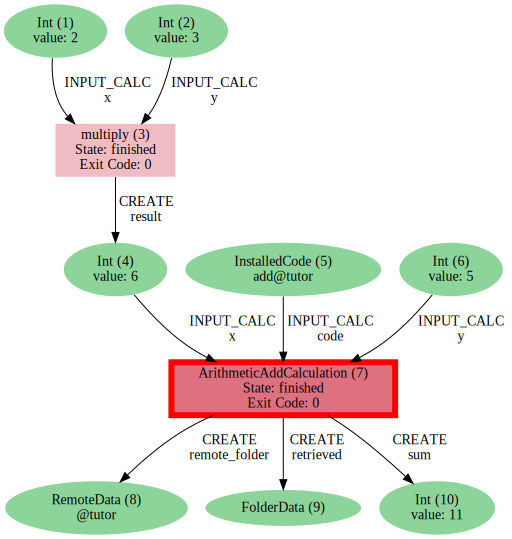

In [22]:
from aiida.tools.visualization import Graph
graph = Graph()
calc_node = orm.load_node(7)
graph.recurse_ancestors(calc_node, annotate_links="both")
graph.add_outgoing(calc_node, annotate_links="both")
graph.graphviz

You can see more details on any process, including its inputs and outputs, using the verdi shell:

In [23]:
%verdi process show 7

Property     Value
-----------  ------------------------------------
type         ArithmeticAddCalculation
state        Finished [0]
pk           7
uuid         21c842fb-7902-45bb-be66-a49c89b2ad67
label
description
ctime        2024-05-05 04:12:21.923547+00:00
mtime        2024-05-05 04:12:23.090713+00:00
computer     [1] tutor

Inputs      PK  Type
--------  ----  -------------
code         5  InstalledCode
x            4  Int
y            6  Int

Outputs          PK  Type
-------------  ----  ----------
remote_folder     8  RemoteData
retrieved         9  FolderData
sum              10  Int


## Workflows

So far we have executed each process manually.
AiiDA allows us to automate these steps by linking them together in a *workflow*, whose provenance is stored to ensure reproducibility.
For this tutorial we have prepared a basic `WorkChain` that is already implemented in `aiida-core`.
You can see the code below:

:::{dropdown} MultiplyAddWorkChain code

```{literalinclude} ../../../src/aiida/workflows/arithmetic/multiply_add.py
:language: python
:start-after: start-marker
```

First, we recognize the `multiply` function we have used earlier, decorated as a `calcfunction`.
The `define` class method specifies the `input` and `output` of the `WorkChain`, as well as the `outline`, which are the steps of the workflow.
These steps are provided as methods of the `MultiplyAddWorkChain` class.

:::

In [24]:
from aiida.engine import ToContext, WorkChain, calcfunction
from aiida.orm import AbstractCode, Int
from aiida.plugins.factories import CalculationFactory

ArithmeticAddCalculation = CalculationFactory('core.arithmetic.add')


@calcfunction
def multiply(x, y):
    return x * y


class MultiplyAddWorkChain(WorkChain):
    """WorkChain to multiply two numbers and add a third, for testing and demonstration purposes."""

    @classmethod
    def define(cls, spec):
        """Specify inputs and outputs."""
        super().define(spec)
        spec.input('x', valid_type=Int)
        spec.input('y', valid_type=Int)
        spec.input('z', valid_type=Int)
        spec.input('code', valid_type=AbstractCode)
        spec.outline(
            cls.multiply,
            cls.add,
            cls.validate_result,
            cls.result,
        )
        spec.output('result', valid_type=Int)
        spec.exit_code(400, 'ERROR_NEGATIVE_NUMBER', message='The result is a negative number.')

    def multiply(self):
        """Multiply two integers."""
        self.ctx.product = multiply(self.inputs.x, self.inputs.y)

    def add(self):
        """Add two numbers using the `ArithmeticAddCalculation` calculation job plugin."""
        inputs = {'x': self.ctx.product, 'y': self.inputs.z, 'code': self.inputs.code}
        future = self.submit(ArithmeticAddCalculation, **inputs)

        return ToContext(addition=future)

    def validate_result(self):
        """Make sure the result is not negative."""
        result = self.ctx.addition.outputs.sum

        if result.value < 0:
            return self.exit_codes.ERROR_NEGATIVE_NUMBER

    def result(self):
        """Add the result to the outputs."""
        self.out('result', self.ctx.addition.outputs.sum)

:::{note}
Besides WorkChain's, workflows can also be implemented as {ref}`work functions <topics:workflows:concepts:workfunctions>`.
These are ideal for workflows that are not very computationally intensive and can be easily implemented in a Python function.
:::

Let's run the `WorkChain` above!

Start up the `verdi shell` and load the `MultiplyAddWorkChain` using the `WorkflowFactory`:

In [25]:
from aiida import plugins
MultiplyAddWorkChain = plugins.WorkflowFactory('core.arithmetic.multiply_add')

The `WorkflowFactory` loads workflows based on their {ref}`entry point <topics:plugins:entrypoints>`, e.g. `'core.arithmetic.multiply_add'` in this case.
The entry point mechanism allows AiiDA to automatically discover workflows provided by  `aiida-core` and {ref}`AiiDA plugins <how-to:plugins-install>`, and display them to the user, e.g. via `verdi plugin list aiida.workflows`. Pass the entry point as an argument to display detailed information, e.g. via `verdi plugin list aiida.workflows core.arithmetic.multiply_add`.

Similar to a `CalcJob`, the `WorkChain` input can be set up using a builder:

In [26]:
from aiida import orm
builder = MultiplyAddWorkChain.get_builder()
builder.code = orm.load_code(label='add')
builder.x = orm.Int(2)
builder.y = orm.Int(3)
builder.z = orm.Int(5)
builder

Process class: MultiplyAddWorkChain
Inputs:
code: add@tutor
metadata: {}
x: 2
y: 3
z: 5


Once the `WorkChain` input has been set up, we run it with the AiiDA engine:

In [27]:
from aiida import engine
engine.run(builder)

{'result': <Int: uuid: 1523e37d-0edb-471e-a6e1-ee8410e4c486 (pk: 20) value: 11>}

Now quickly leave the IPython shell and check the process list:

In [28]:
%verdi process list -a

  PK  Created    Process label             ♻    Process State    Process status
----  ---------  ------------------------  ---  ---------------  ----------------
   3  5s ago     multiply                       ⏹ Finished [0]
   7  3s ago     ArithmeticAddCalculation       ⏹ Finished [0]
  14  2s ago     MultiplyAddWorkChain           ⏹ Finished [0]
  15  1s ago     multiply                       ⏹ Finished [0]
  17  1s ago     ArithmeticAddCalculation       ⏹ Finished [0]

Total results: 5

Report: ♻ Processes marked with check-mark were not run but taken from the cache.
Report: Add the option `-P pk cached_from` to the command to display cache source.
Report: Last time an entry changed state: 0s ago (at 04:12:25 on 2024-05-05)



Total results: 5



Report: ♻ Processes marked with check-mark were not run but taken from the cache.


Report: Add the option `-P pk cached_from` to the command to display cache source.


Report: Last time an entry changed state: 0s ago (at 04:12:25 on 2024-05-05)


:::{dropdown} Submitting to the daemon

If instead we had submitted to the daemon (see {ref}`tutorial:daemon`), we would see the the process status of the workchain and its dependants:

```console
$ verdi process list -a
  PK  Created    Process label             Process State    Process status
----  ---------  ------------------------  ---------------  ------------------------------------
   3  7m ago     multiply                  ⏹ Finished [0]
   7  3m ago     ArithmeticAddCalculation  ⏹ Finished [0]
  12  2m ago     ArithmeticAddCalculation  ⏹ Finished [0]
  19  16s ago    MultiplyAddWorkChain      ⏵ Waiting        Waiting for child processes: 22
  20  16s ago    multiply                  ⏹ Finished [0]
  22  15s ago    ArithmeticAddCalculation  ⏵ Waiting        Waiting for transport task: retrieve

Total results: 6

Info: last time an entry changed state: 0s ago (at 09:08:59 on 2020-05-13)
```

:::

We can see that the `MultiplyAddWorkChain` is currently waiting for its *child process*, the `ArithmeticAddCalculation`, to finish.
Check the process list again for *all* processes (You should know how by now!).
After about half a minute, all the processes should be in the `Finished` state.
The `verdi process status` command prints a *hierarchical* overview of the processes called by the work chain:

In [29]:
%verdi process status 14

MultiplyAddWorkChain<14> Finished [0] [3:result]
    ├── multiply<15> Finished [0]
    └── ArithmeticAddCalculation<17> Finished [0]


The bracket `[3:result]` indicates the current step in the outline of the {py:class}`~aiida.workflows.arithmetic.multiply_add.MultiplyAddWorkChain` (step 3, with name `result`).
The `process status` is particularly useful for debugging complex work chains, since it helps pinpoint where a problem occurred.

We can now generate the full provenance graph for the `WorkChain` with:

```console
$ verdi node graph generate 14
```

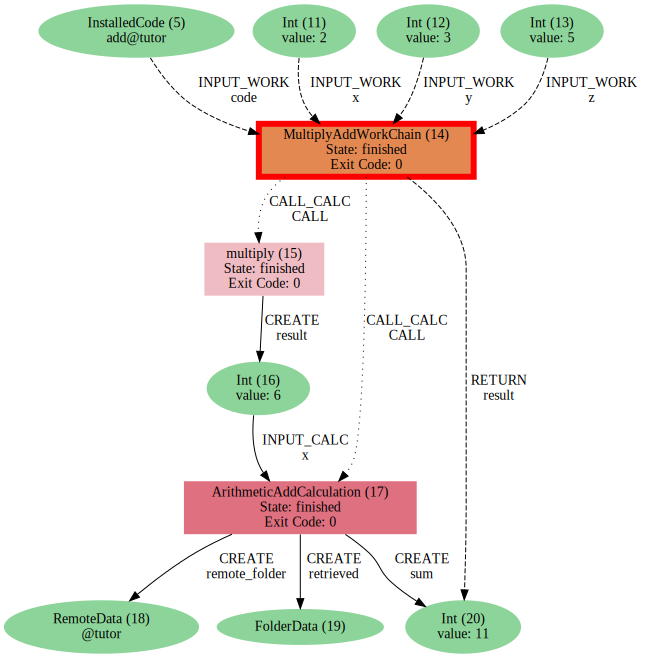

In [30]:
from aiida.tools.visualization import Graph
graph = Graph()
calc_node = orm.load_node(14)
graph.recurse_ancestors(calc_node, annotate_links="both")
graph.recurse_descendants(calc_node, annotate_links="both")
graph.graphviz

Look familiar?
The provenance graph should be similar to the one we showed at the start of this tutorial ({numref}`fig_intro_workchain_graph`).

(tutorial:daemon)=

## Submitting to the daemon

When we used the `run` command in the previous sections, the IPython shell was blocked while it was waiting for the `CalcJob` to finish.
This is not a problem when we're simply adding two number together, but if we want to run multiple calculations that take hours or days, this is no longer practical.
Instead, we are going to *submit* the `CalcJob` to the AiiDA *daemon*.
The daemon is a program that runs in the background and manages submitted calculations until they are *terminated*.
Let's first check the status of the daemon using the `verdi` CLI:

```console
$ verdi daemon status
```

If the daemon is running, the output will be something like the following:

```bash
Profile: tutorial
Daemon is running as PID 96447 since 2020-05-22 18:04:39
Active workers [1]:
  PID    MEM %    CPU %  started
-----  -------  -------  -------------------
96448    0.507        0  2020-05-22 18:04:39
Use verdi daemon [incr | decr] [num] to increase / decrease the amount of workers
```

In this case, let's stop it for now:

```console
$ verdi daemon stop
```

Next, let's *submit* the `CalcJob` we ran previously.
Start the `verdi shell` and execute the Python code snippet below.
This follows all the steps we did previously, but now uses the `submit` function instead of `run`:

```ipython
In [1]: from aiida.engine import submit
   ...:
   ...: code = load_code(label='add')
   ...: builder = code.get_builder()
   ...: builder.x = load_node(pk=4)
   ...: builder.y = Int(5)
   ...:
   ...: submit(builder)
```

When using `submit` the calculation job is not run in the local interpreter but is sent off to the daemon and you get back control instantly.
Instead of the *result* of the calculation, it returns the node of the `CalcJob` that was just submitted:

```ipython
Out[1]: <CalcJobNode: uuid: e221cf69-5027-4bb4-a3c9-e649b435393b (pk: 12) (aiida.calculations:core.arithmetic.add)>
```

Let's exit the IPython shell and have a look at the process list:

```console
$ verdi process list
```

You should see the `CalcJob` you have just submitted, with the state `Created`:

```bash
  PK  Created    Process label             Process State    Process status
----  ---------  ------------------------  ---------------  ----------------
  12  13s ago    ArithmeticAddCalculation  ⏹ Created

Total results: 1

Info: last time an entry changed state: 13s ago (at 09:06:57 on 2020-05-13)
```

The `CalcJob` process is now waiting to be picked up by a daemon runner, but the daemon is currently disabled.
Let's start it up (again):

```console
$ verdi daemon start
```

Now you can either use `verdi process list` to follow the execution of the `CalcJob`, or `watch` its progress:

```console
$ verdi process watch 12
```

Let's wait for the `CalcJob` to complete and then use `verdi process list -a` to see all processes we have run so far:

```bash
  PK  Created    Process label             Process State    Process status
----  ---------  ------------------------  ---------------  ----------------
   3  6m ago     multiply                  ⏹ Finished [0]
   7  2m ago     ArithmeticAddCalculation  ⏹ Finished [0]
  12  1m ago     ArithmeticAddCalculation  ⏹ Finished [0]

Total results: 3

Info: last time an entry changed state: 14s ago (at 09:07:45 on 2020-05-13)
```

(tutorial:next-steps)=

# Next Steps

Congratulations! You have completed the first step to becoming an AiiDA expert.

We have compiled how-to guides that are especially relevant for the following use cases:

::::{div} dropdown-group

:::{dropdown} Run pure Python lightweight computations

Designing a workflow
: After reading the {ref}`Basic Tutorial <tutorial:basic>`, you may want to learn about how to encode the logic of a typical scientific workflow in the {ref}`writing workflows how-to <how-to:write-workflows>`.

Reusable data types
: If you have a certain input or output data type, which you use often, then you may wish to turn it into its own {ref}`data plugin <topics:data_types:plugin>`.

Finding and querying for your data
: Once you have run multiple computations, the {ref}`find and query data how-to <how-to:query>` can show you how to efficiently explore your data. The data lineage can also be visualised as a {ref}`provenance graph <how-to:data:visualise-provenance>`.

Sharing your data
: You can export all or part of your data to file with the {ref}`export/import functionality<how-to:share:archives>` or you can even serve your data over HTTP(S) using the {ref}`AiiDA REST API <how-to:share:serve>`.

Sharing your workflows
: Once you have a working computation workflow, you may also wish to {ref}`package it into a python module <how-to:plugins-develop>` for others to use.

:::
:::{dropdown} Run compute-intensive codes

Working with external codes
: Existing calculation plugins, for interfacing with external codes, are available on the [aiida plugin registry](https://aiidateam.github.io/aiida-registry/).
  If none meet your needs, then the {ref}`external codes how-to <how-to:plugin-codes>` can show you how to create your own calculation plugin.

Tuning performance
: To optimise the performance of AiiDA for running many concurrent computations see the {ref}`tuning performance how-to <how-to:installation:performance>`.

Saving computational resources
: AiiDA can cache and reuse the outputs of identical computations, as described in the {ref}`caching how-to <how-to:run-codes:caching>`.

:::
:::{dropdown} Run computations on High Performance Computers

Connecting to supercomputers
: To setup up a computer which can communicate with a high-performance computer over SSH, see the {ref}`how-to for running external codes <how-to:run-codes>`, or add a {ref}`custom transport <topics:transport:develop_plugin>`.
  AiiDA has pre-written scheduler plugins to work with LSF, PBSPro, SGE, Slurm and Torque.

Working with external codes
: Existing calculation plugins, for interfacing with external codes, are available on the [aiida plugin registry](https://aiidateam.github.io/aiida-registry/).
  If none meet your needs, then the {ref}`external codes how-to <how-to:plugin-codes>` can show you how to create your own calculation plugin.

Exploring your data
: Once you have run multiple computations, the {ref}`find and query data how-to <how-to:query>` can show you how to efficiently explore your data. The data lineage can also be visualised as a {ref}`provenance graph <how-to:data:visualise-provenance>`.

Sharing your data
: You can export all or part of your data to file with the {ref}`export/import functionality<how-to:share:archives>` or you can even serve your data over HTTP(S) using the {ref}`AiiDA REST API <how-to:share:serve>`.

Sharing your calculation plugin
: Once you have a working plugin, you may also wish to {ref}`package it into a python module <how-to:plugins-develop>` for others to use.

:::
::::

% You can do more with AiiDA than basic arithmetic! Check out some cool real-world examples of AiiDA in action on the demo page <LINK HERE>

```{todo}
Add to "Connecting to supercomputers": , or you can add a {ref}`custom scheduler <topics:schedulers:develop_plugin>`.
```